# Research on the recommendation of mobile tariffs

## Data

In [42]:
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree

Let's upload data, look at info and descriptive statistics.

In [43]:
df = pd.read_csv('users_behavior.csv')
    
display(df.head())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [45]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Now let's check data for missing values and duplicates.

In [46]:
print(df.isna().sum())

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64


In [47]:
print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 0


Next let's look at variables distribution.

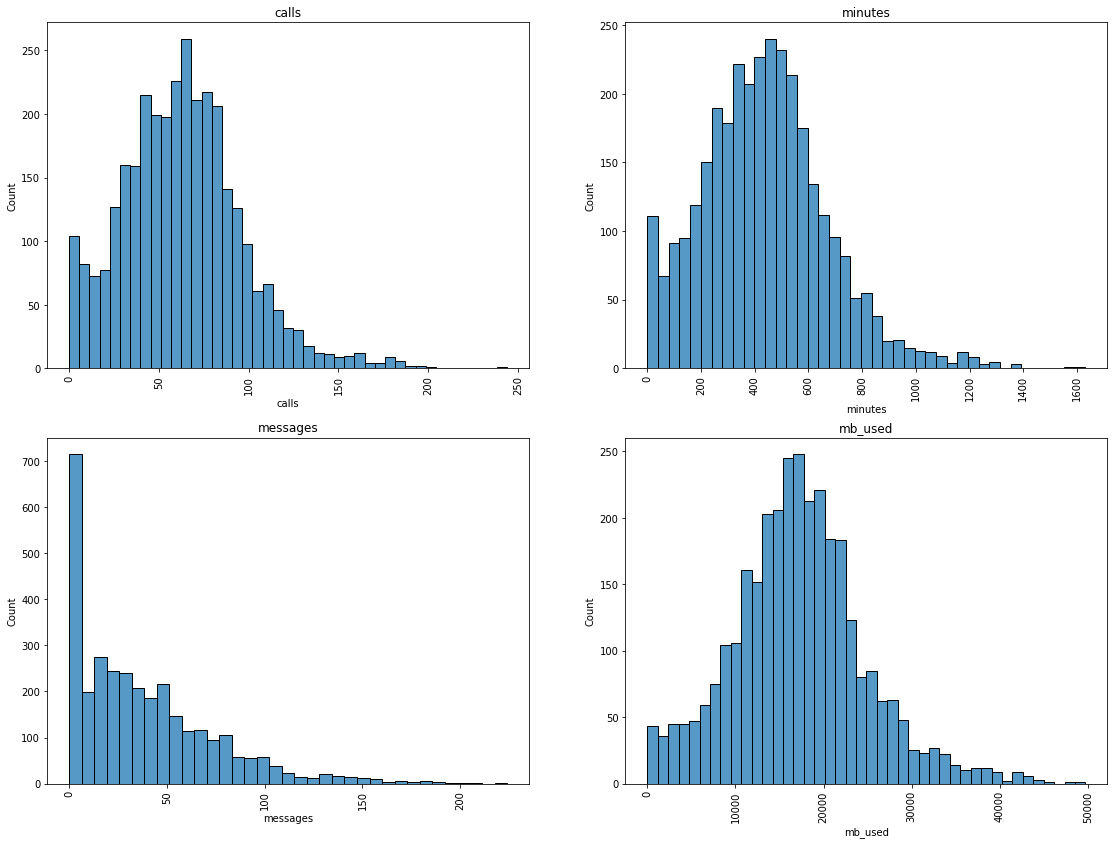

In [48]:
_, axs = plt.subplots(2, 2, figsize=(19,14))
axs = axs.ravel()
names = df.drop(['is_ultra'], axis=1).columns

for i in range(len(names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df[names[i]], data=df)
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_title(names[i])

In [49]:
print('Unique values in "is_ultra" variable:', df['is_ultra'].unique())

Unique values in "is_ultra" variable: [0 1]


Sample is unbalanced. Far fewer people use "Ultra" tariff compared to those who use "Smart" plan.

In [50]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

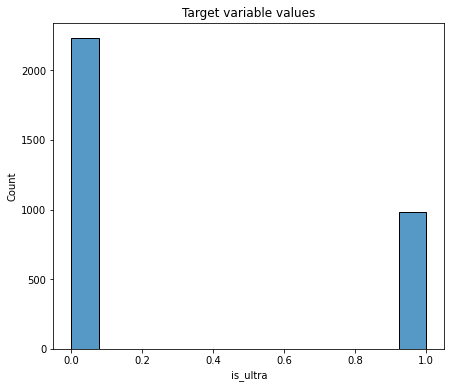

In [51]:
plt.figure(figsize=(7,6))
sns.histplot(x=df['is_ultra'], data=df)
plt.title('Target variable values')
plt.show()

**Summary:** Data type of variables is not needed to be changed. In additions, there are no missing values or duplicates in data. Distributions of the `calls`, `minutes`, `mb_users` variables is right-skewed and close to the normal. Distribution of the `messages` variable is also right-skewed - in most cases people don't use SMS. The dependent variable `is_ultra` is binary and takes the value of 1 if person uses the "Ultra" tariff. Since the variable is binary, we have to use classification models.

Variable `minutes` is highly correlated with `calls` variable. It can affect the results of a linear classifier. Let's remove one of the features (`minutes`) to avoid multicollinearity.

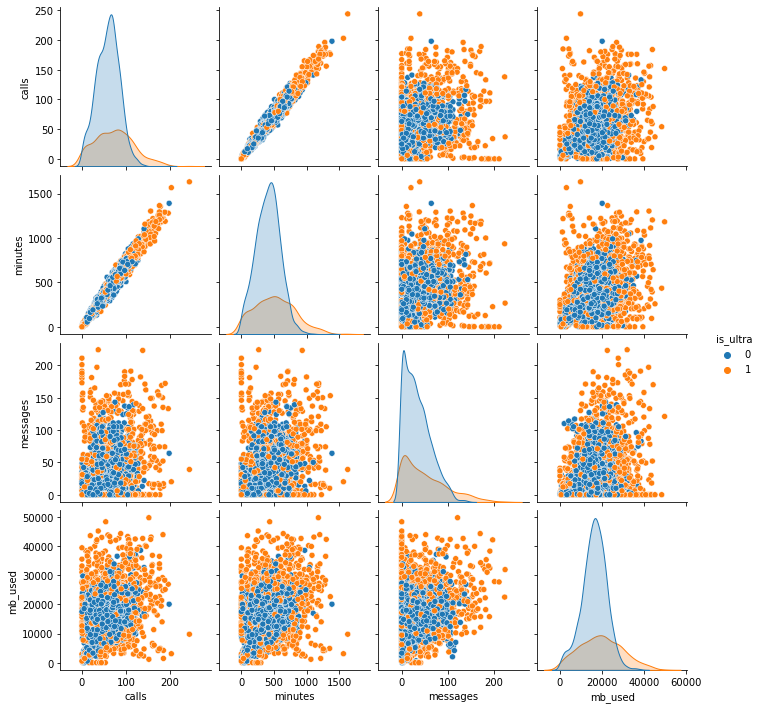

In [52]:
sns.pairplot(df, hue='is_ultra')
plt.show()

In [53]:
df = df.drop('minutes', axis=1).copy()

## Train and test samples split

Let's get `is_ultra` variable and assign it to `target`. Then, let's assign independent variables to `features`.

In [54]:
target = df['is_ultra']
features = df.drop(['is_ultra'], axis = 1)

Let's split sample into training, validation and test in proportion 60%, 20%, 20%, respectively. 

In [55]:
features_train, features_valid, target_train, target_valid = \
train_test_split(features, target, test_size=0.4, random_state=42)

features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid, target_valid, test_size=0.5, random_state=42)

Let's check the size of the resulting samples.

In [24]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(1928, 3) (1928,)
(643, 3) (643,)
(643, 3) (643,)


Let's check whether the resulting samples match.

In [15]:
(features_valid.reset_index(drop=True) == features_test.reset_index(drop=True)).all().sum()

0

In [16]:
(target_valid.reset_index(drop=True) == target_test.reset_index(drop=True)).all().sum()

0

Let's check whether the original distribution of the dependent variable is the same in three samples.

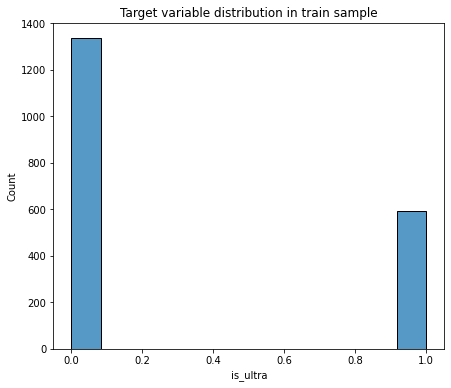

In [17]:
plt.figure(figsize=(7,6))
sns.histplot(x=target_train)
plt.title('Target variable distribution in train sample')
plt.show()

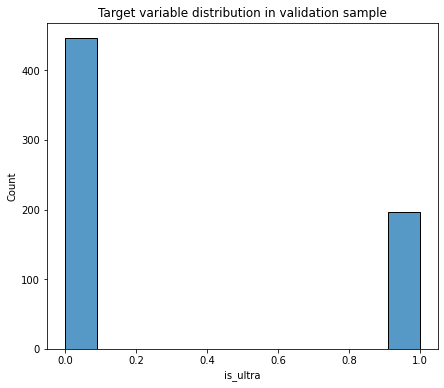

In [18]:
plt.figure(figsize=(7,6))
sns.histplot(x=target_valid)
plt.title('Target variable distribution in validation sample')
plt.show()

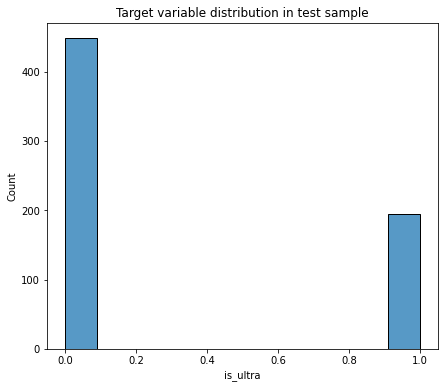

In [19]:
plt.figure(figsize=(7,6))
sns.histplot(x=target_test)
plt.title('Target variable distribution in test sample')
plt.show()

**Summary:** Samples for training, validation and test are ready.

## Model selection

The first model we will explore is the decision tree classifier. Firstly, let's explore key features used in decision tree classification.

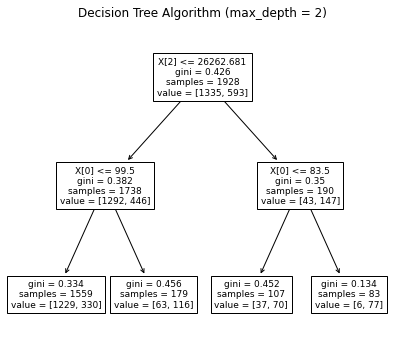

In [20]:
plt.figure(figsize=(7,6))
model_tree_plot = DecisionTreeClassifier(max_depth=2, random_state=42)
model_tree_plot.fit(features_train, target_train)
tree.plot_tree(model_tree_plot)
plt.title('Decision Tree Algorithm (max_depth = 2)')
plt.show()

Let's iterate over the hyperparameters: `max_depth` (maximum depth of the tree), `min_samples_split` (the minimum number of samples required to split an internal node), `min_samples_leaf` (the minimum number of samples required to be at a leaf node).

In [35]:
%%time

train = []
validation = []
best_model_tree = None
accuracy = 0
for depth in range(1, 15):
    for split in range(2, 5):
        for leaf in range(1,4):
            model_tree = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, random_state=42)
            model_tree.fit(features_train, target_train)
            new_accuracy = model_tree.score(features_valid, target_valid)
            if new_accuracy > accuracy:
                accuracy = new_accuracy
                best_model_tree = model_tree
                train.append(model_tree.score(features_train, target_train))
                validation.append(new_accuracy)

print("Validation accuracy of the best model:", accuracy)

Validation accuracy of the best model: 0.8133748055987559
CPU times: user 763 ms, sys: 5.73 ms, total: 769 ms
Wall time: 767 ms


Let's see how the train and validation accuracy changed.

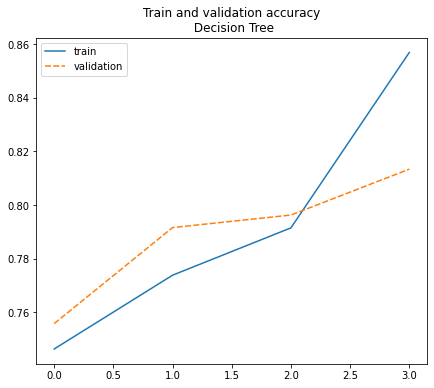

In [36]:
plt.figure(figsize=(7,6))
dat_plot = pd.DataFrame({'train':train, 'validation':validation})
sns.lineplot(data=dat_plot)
plt.title('Train and validation accuracy\n Decision Tree')
plt.show()

As a result, the proportion of correct answers in the validation sample is high. Let us derive the hyperparameter values of the best decision tree.

In [30]:
best_model_tree.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(max_depth=8, random_state=42)>

As we can see the best hyperparameters for `min_samples_split` and `min_samples_leaf` is the default values – 2 and 1 respectively.

Now let's fit random forest. Firstly, let's iterate over the hyperparameters: `max_depth`, `min_samples_split`, `min_samples_leaf` and `n_estimators` (number of estimators - trees).

In [37]:
%%time

train = []
validation = []
best_model_forest = None
accuracy = 0
for depth in range(1, 15):
    for split in range(2, 5):
        for leaf in range(1,4):
            for est in range(10, 150, 10):
                model_forest = RandomForestClassifier(n_estimators = est, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, random_state=42)
                model_forest.fit(features_train, target_train)
                new_accuracy = model_forest.score(features_valid, target_valid)
                if new_accuracy > accuracy:
                    accuracy = new_accuracy
                    best_model_forest = model_forest
                    train.append(model_forest.score(features_train, target_train))
                    validation.append(new_accuracy)

print("Validation accuracy of the best model", accuracy)

Validation accuracy of the best model 0.8242612752721618
CPU times: user 4min 25s, sys: 1.3 s, total: 4min 26s
Wall time: 4min 26s


Training time has increased. Let's see how the train and validation accuracy changed.

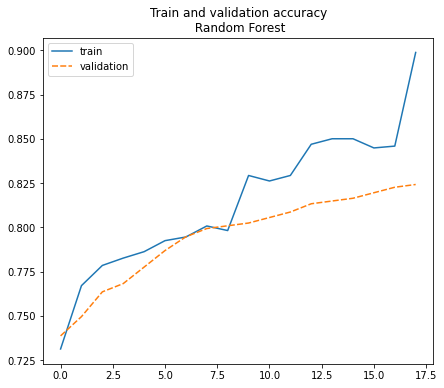

In [38]:
plt.figure(figsize=(7,6))
dat_plot = pd.DataFrame({'train':train, 'validation':validation})
sns.lineplot(data=dat_plot)
plt.title('Train and validation accuracy\n Random Forest')
plt.show()

The proportion of correct answers in the validation sample is even higher. Let's derive the hyperparameter values of the best model.

In [39]:
best_model_forest

RandomForestClassifier(max_depth=14, min_samples_leaf=2, n_estimators=40,
                       random_state=42)

Finally, let's fit logistic regression. The accuracy is lower compared to the decision tree and random forest models. However, training time is fast.

In [40]:
%%time 

model_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000) 
model_log.fit(features_train, target_train)
print("Validation accuracy:", model_log.score(features_valid, target_valid))

Validation accuracy: 0.7247278382581649
CPU times: user 20.5 ms, sys: 6.69 ms, total: 27.2 ms
Wall time: 34.9 ms


## Test accuracy

Random forest model has the best validation accuracy. Therefore, we will use this model to predict the suitable tarrif for customers.

Test accuracy is slightly lower than validation one, but it is still high (0.8). The graph shows how many false positive and false negative answers we get using random forest.

In [56]:
print('Test accuracy (Random Forest):',best_model_forest.score(features_test, target_test))

Test accuracy (Random Forest): 0.8087091757387247


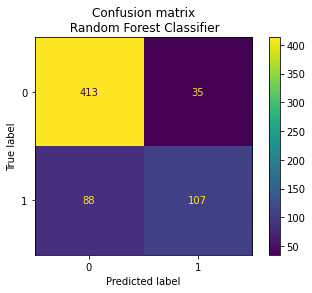

In [59]:
cm = confusion_matrix(target_test, best_model_forest.predict(features_test), labels=best_model_forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_model_forest.classes_)
disp.plot()
plt.title('Confusion matrix\n Random Forest Classifier')
plt.show()

## Conclusion

To conclude, we fit three different models to predict the mobile tariff. We found that Decision Tree Classifier is quick and has good accuracy. Random Forest Classifier works slowly but has the best accuracy rate. Logistic Regression is really fast in training, but accuracy is low. Results are summarised in table below.

| Model | Wall time | Accuracy |
| --- | --- | --- |
| Decision Tree Classifier | average | average|
| Random Forest Classifier | low | high |
| Logistic Regression | high | low |

## Dummy Classifier Check

Let's check the Random Forest Classifier results using the Dummy Classifier, that makes predictions that ignore the input features.

In [58]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(features_train, target_train)
dummy_clf.score(features_test, target_test)

0.5101088646967341

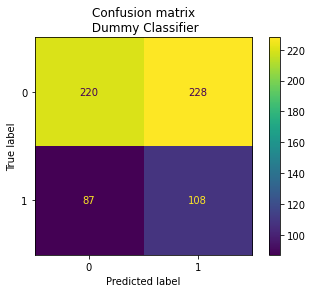

In [60]:
cm = confusion_matrix(target_test, dummy_clf.predict(features_test), labels=dummy_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dummy_clf.classes_)
disp.plot()
plt.title('Confusion matrix\n Dummy Classifier')
plt.show()

Thus, we have improved the quality of classification by using Random Forest Classifier.